# Neural Network model development
Created by Ivan Lima on Wed Nov 10 2021 11:10:06 -0500

In this notebook we develop a neural network model to predict DIC and TA from the merged bottle and satellite data using pytorch.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, datetime, warnings
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Mon Nov 29 14:45:14 2021


In [2]:
sns.set_theme(context='paper', style='ticks', palette='tab10', rc={'figure.dpi':100, 'figure.figsize':[5, 5], 'axes.grid':True})
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')

## Read merged bottle satellite data 

In [3]:
df = pd.read_csv('data/bottle_satellite_data_clean.csv', parse_dates=['Date'], index_col=0)

## Select input features and split data into training and test sets 

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Set input and output variables
features = ['Depth', 'bottom_depth', 'Temperature', 'Salinity', 'Oxygen', 'pCO2_monthave', 'SLA', 'SST_hires', 'KD490']
targets  = ['DIC', 'TA']

X_numpy = df[features].values
Y_numpy = df[targets].values

# Split data into training and test sets
X_numpy_train, X_numpy_test, Y_numpy_train, Y_numpy_test = train_test_split(X_numpy, Y_numpy, random_state=42)

### Correlation between feature and target variables 

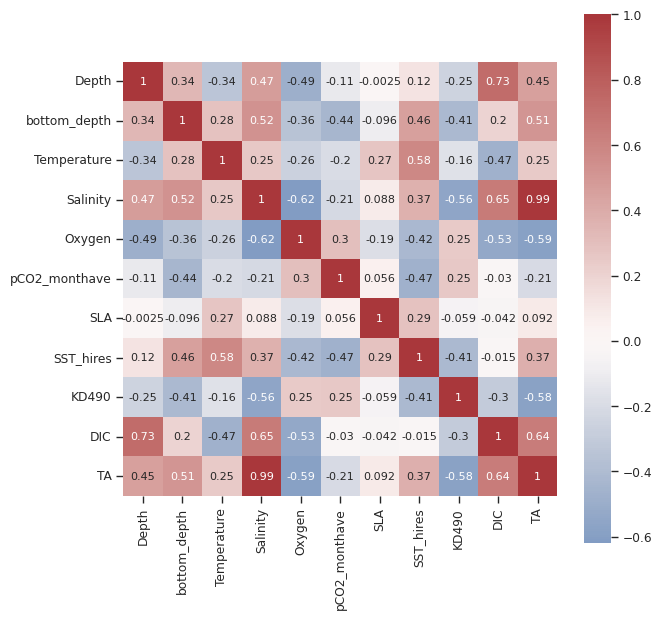

In [5]:
data = df[features + targets]
corr_mat = data.corr()
fig, ax = plt.subplots(figsize=(7,7))
_ = sns.heatmap(corr_mat, ax=ax, cmap='vlag', center=0, square=True, annot=True, annot_kws={'fontsize':8})

## Rescale data 

Neural networks are very sensitive to the scale and distribution of each feature. Therefore, we rescale input features so they have $\overline{x}=0$ and $\sigma=1$.

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler = StandardScaler().fit(X_numpy_train)
X_numpy_train_scaled = scaler.transform(X_numpy_train)
X_numpy_test_scaled = scaler.transform(X_numpy_test)
X_numpy_scaled = scaler.transform(X_numpy)

## Neural Network regression 

In [7]:
import torch
import torch.nn as nn

# # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # device

# convert numpy arrays to pytorch tensors
X_train = torch.from_numpy(X_numpy_train_scaled.astype(np.float32))
Y_train = torch.from_numpy(Y_numpy_train.astype(np.float32))
# print('X size: {}\nY size: {}'.format(X_train.size(), Y_train.size()))

# set neural network parameters
n_features = X_train.size()[1] # number of input variables
n_targets = Y_train.size()[1]  # number of output variables
n_hidden = 256                 # number of hidden layers
learning_rate = 0.001

torch.manual_seed(42) # set random number seed to make things reproducible

# create neural network regression model
class MLPReg(nn.Module):
    def __init__(self, n_features, n_hidden, n_targets):
        super(MLPReg, self).__init__()
        self.l1    = nn.Linear(n_features, n_hidden)
        self.l2    = nn.Linear(n_hidden, n_hidden)
        self.l3    = nn.Linear(n_hidden, n_targets)
        self.activ = nn.LeakyReLU()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.activ(out)
        out = self.l2(out)
        out = self.activ(out)
        out = self.l3(out)
        return out

nn_reg = MLPReg(n_features=n_features, n_hidden=n_hidden, n_targets=n_targets) # create model instance
print(nn_reg)

loss_func = nn.MSELoss()                                                      # loss function (mean square error)
optimizer = torch.optim.Adam(nn_reg.parameters(), lr=learning_rate)           # optimizer

loss_vals = [] # keep loss function values for plotting

# train the model
n_passes = 35000
for n in range(n_passes):
    # forward pass
    prediction = nn_reg(X_train)
    loss = loss_func(prediction, Y_train)
    # backward pass
    optimizer.zero_grad()   # clear accumulated gradients for next pass
    loss.backward()         # do backpropagation to compute gradients
    optimizer.step()        # apply gradients to update parameters
    loss_vals.append(loss.item())
    if (n==0) or ((n+1) % 1000 == 0):
        print('pass {:5d}/{}, MSE={:.2f}'.format(n+1, n_passes, loss.item()))

MLPReg(
  (l1): Linear(in_features=9, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=2, bias=True)
  (activ): LeakyReLU(negative_slope=0.01)
)
pass     1/35000, MSE=4726428.00
pass  1000/35000, MSE=28037.95
pass  2000/35000, MSE=4931.09
pass  3000/35000, MSE=333.36
pass  4000/35000, MSE=190.13
pass  5000/35000, MSE=154.80
pass  6000/35000, MSE=138.29
pass  7000/35000, MSE=125.88
pass  8000/35000, MSE=113.86
pass  9000/35000, MSE=104.00
pass 10000/35000, MSE=94.86
pass 11000/35000, MSE=87.67
pass 12000/35000, MSE=81.30
pass 13000/35000, MSE=76.35
pass 14000/35000, MSE=73.39
pass 15000/35000, MSE=61.97
pass 16000/35000, MSE=57.26
pass 17000/35000, MSE=53.48
pass 18000/35000, MSE=50.54
pass 19000/35000, MSE=47.35
pass 20000/35000, MSE=44.21
pass 21000/35000, MSE=41.28
pass 22000/35000, MSE=39.13
pass 23000/35000, MSE=36.47
pass 24000/35000, MSE=36.04
pass 25000/35000, MSE=33.05
pass 26000/35000, MSE=32

### Loss function as function of number of passes

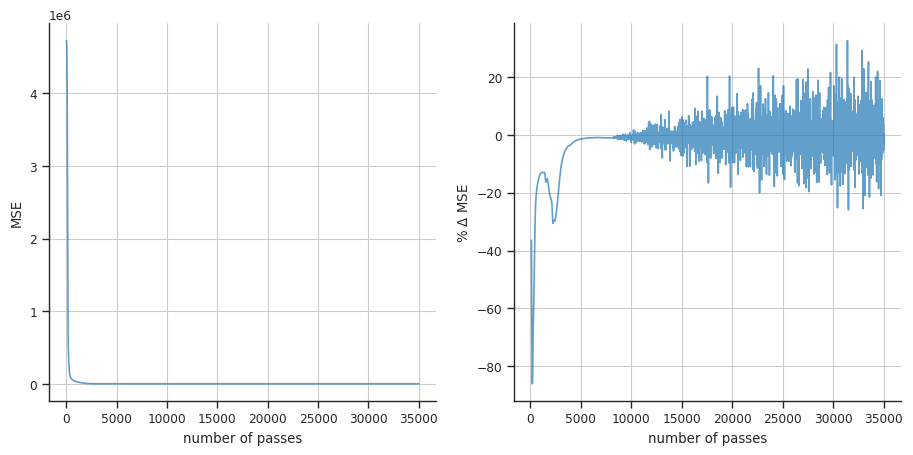

In [8]:
df = pd.DataFrame({'MSE': np.array(loss_vals)})
df['pct_change'] = df.MSE.pct_change(100) * 100
fig, axs = plt.subplots(1, 2, figsize=(11, 5))
_ = df.MSE.plot(ax=axs[0], alpha=0.7, legend=False)
_ = df['pct_change'].plot(ax=axs[1], alpha=0.7, legend=False)
_ = axs[0].set(ylabel='MSE', xlabel='number of passes')
_ = axs[1].set(ylabel=r'% $\Delta$ MSE', xlabel='number of passes')
sns.despine(fig)

### Evaluate model on test set

In [9]:
from sklearn.metrics import r2_score

X_test = torch.from_numpy(X_numpy_test_scaled.astype(np.float32))
with torch.no_grad():
    Y_pred_train = nn_reg(X_train)
    Y_pred_test  = nn_reg(X_test)

print('Training set R squared: {:.3f}'.format(r2_score(Y_pred_train, Y_numpy_train)))
print('Test set R squared:     {:.3f}'.format(r2_score(Y_pred_test, Y_numpy_test)))

Training set R squared: 0.995
Test set R squared:     0.958


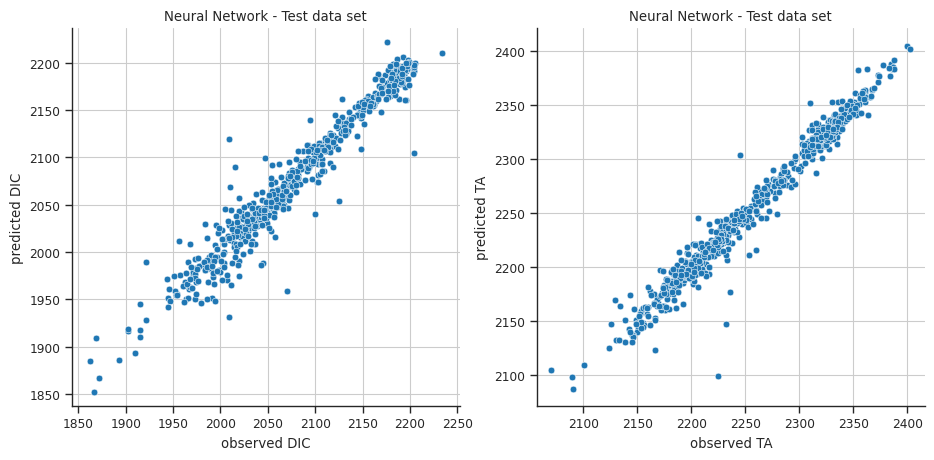

In [10]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(11, 5))
_ = sns.scatterplot(x=Y_numpy_test[:,0], y=Y_pred_test[:,0], ax=ax0)
_ = sns.scatterplot(x=Y_numpy_test[:,1], y=Y_pred_test[:,1], ax=ax1)
_ = ax0.set(xlabel='observed DIC', ylabel='predicted DIC', title='Neural Network - Test data set')
_ = ax1.set(xlabel='observed TA', ylabel='predicted TA', title='Neural Network - Test data set')
ax0.axis('equal')
ax1.axis('equal')
sns.despine(fig)

### Do k-fold cross-validation

In [11]:
torch.manual_seed(42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def reset_weights(m):
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

nnr_model = MLPReg(n_features=n_features, n_hidden=n_hidden, n_targets=n_targets)

loss_func = nn.MSELoss() # loss function (mean square error)
optimizer = torch.optim.Adam(nnr_model.parameters(), lr=learning_rate) # optimizer

score_vals = [] # store score values

for k, (train_idx, test_idx) in enumerate(kf.split(X_numpy)):
    # rescale input data
    X_tr, X_te = X_numpy[train_idx], X_numpy[test_idx]
    ss = StandardScaler().fit(X_tr)
    X_tr_sc = ss.transform(X_tr)
    X_te_sc = ss.transform(X_te)
    
    # convert numpy arrays to tensors
    X = torch.from_numpy(X_tr_sc.astype(np.float32))
    Y = torch.from_numpy(Y_numpy[train_idx].astype(np.float32))

    # reset model weights to avoid weight leakage
    nnr_model.apply(reset_weights)
    
    # train the model
    ntot = n_passes
    for n in range(ntot):
        # forward pass
        prediction = nnr_model(X)
        loss = loss_func(prediction, Y)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (n==0) or ((n+1) % 1000 == 0):
            print('pass {:5d}/{}, MSE={:.2f}'.format(n+1, ntot, loss.item()))
    
    # evaluate model
    xx = torch.from_numpy(X_te_sc.astype(np.float32))
    with torch.no_grad():
        Y_pred  = nnr_model(xx)
        score = r2_score(Y_pred, Y_numpy[test_idx])
        score_vals.append(score)
        print('Fold {} test set R squared: {:.3f}\n'.format(k+1, score))

Reset trainable parameters of layer = Linear(in_features=9, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=2, bias=True)
pass     1/35000, MSE=4726197.00
pass  1000/35000, MSE=29758.70
pass  2000/35000, MSE=6107.82
pass  3000/35000, MSE=510.60
pass  4000/35000, MSE=200.79
pass  5000/35000, MSE=153.42
pass  6000/35000, MSE=131.76
pass  7000/35000, MSE=117.46
pass  8000/35000, MSE=105.42
pass  9000/35000, MSE=93.84
pass 10000/35000, MSE=84.39
pass 11000/35000, MSE=76.95
pass 12000/35000, MSE=71.99
pass 13000/35000, MSE=67.53
pass 14000/35000, MSE=64.41
pass 15000/35000, MSE=61.78
pass 16000/35000, MSE=59.30
pass 17000/35000, MSE=57.56
pass 18000/35000, MSE=56.57
pass 19000/35000, MSE=53.64
pass 20000/35000, MSE=51.94
pass 21000/35000, MSE=49.37
pass 22000/35000, MSE=48.91
pass 23000/35000, MSE=46.57
pass 24000/35000, MSE=47.26
pass 25000/3500

In [12]:
scores = np.array(score_vals)
with np.printoptions(precision=3, suppress=True):
    print('K-fold cross-validation (k=5) R squared values = {}'.format(scores))
print('Best R squared:  {:.3f}'.format(scores.max()))
print('Worst R squared: {:.3f}'.format(scores.min()))
print('Mean R squared:  {:.3f}'.format(scores.mean()))

K-fold cross-validation (k=5) R squared values = [0.969 0.956 0.968 0.967 0.963]
Best R squared:  0.969
Worst R squared: 0.956
Mean R squared:  0.965


### Version using LBFGS optimizer (quasi-Newton method) and ReLU

The LBFGS optimizer is a slower and more computationaly expensive method that works well for smaller data sets. 

In [13]:
torch.manual_seed(42)

# create neural network regression model
class MLPReg2(nn.Module):
    def __init__(self, n_features, n_hidden, n_targets):
        super(MLPReg2, self).__init__()
        self.l1   = nn.Linear(n_features, n_hidden)
        self.l2   = nn.Linear(n_hidden, n_hidden)
        self.l3   = nn.Linear(n_hidden, n_targets)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

nnreg = MLPReg2(n_features=n_features, n_hidden=n_hidden, n_targets=n_targets)
print(nnreg)

l_func = nn.MSELoss()                                              # loss function (mean square error)
opt_func = torch.optim.LBFGS(nnreg.parameters(), lr=learning_rate) # optimizer

# closure function for LBFGS optimizer
def closure():
    opt_func.zero_grad()
    ypred = nnreg(X_train)
    lf = loss_func(ypred, Y_train)
    lf.backward()
    return lf

# train the model
n_passes2 = 320
for n in range(n_passes2):
    # forward pass
    prediction = nnreg(X_train)
    loss = l_func(prediction, Y_train)
    # backward pass
    opt_func.zero_grad()   # clear gradients for next pass
    loss.backward()        # do backpropagation to compute gradients
    opt_func.step(closure) # apply gradients to update parameters
    if (n==0) or ((n+1) % 10 == 0):
        print('pass {:3d}/{}, MSE={:.2f}'.format(n+1, n_passes2, loss.item()))

MLPReg2(
  (l1): Linear(in_features=9, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=2, bias=True)
  (relu): ReLU()
)
pass   1/320, MSE=4726428.50
pass  10/320, MSE=1316227840.00
pass  20/320, MSE=210833904.00
pass  30/320, MSE=30504950.00
pass  40/320, MSE=4460042.50
pass  50/320, MSE=597305.56
pass  60/320, MSE=164160.45
pass  70/320, MSE=104129.12
pass  80/320, MSE=80414.83
pass  90/320, MSE=58823.24
pass 100/320, MSE=39365.01
pass 110/320, MSE=22057.03
pass 120/320, MSE=8440.17
pass 130/320, MSE=3906.65
pass 140/320, MSE=1742.70
pass 150/320, MSE=871.76
pass 160/320, MSE=624.90
pass 170/320, MSE=480.41
pass 180/320, MSE=383.62
pass 190/320, MSE=307.73
pass 200/320, MSE=247.66
pass 210/320, MSE=201.98
pass 220/320, MSE=170.48
pass 230/320, MSE=243.81
pass 240/320, MSE=207.14
pass 250/320, MSE=166.05
pass 260/320, MSE=152.80
pass 270/320, MSE=149.45
pass 280/320, MSE=147.61
pass 290/320, MSE=145.

### Evaluate model on test set

In [14]:
with torch.no_grad():
    Y_pred_train2 = nnreg(X_train)
    Y_pred_test2  = nnreg(X_test)

print('Training set R squared: {:.3f}'.format(r2_score(Y_pred_train2, Y_numpy_train)))
print('Test set R squared:     {:.3f}'.format(r2_score(Y_pred_test2, Y_numpy_test)))

Training set R squared: 0.973
Test set R squared:     0.956
